# Hate speech detection

The data is taken from the repository with the Dynamically Generated Hate Speech Dataset from Vidgen et al. (2021) https://github.com/bvidgen/Dynamically-Generated-Hate-Speech-Dataset.<br>
Reference paper https://aclanthology.org/2021.acl-long.132/

In [ ]:
import numpy as np
import pandas as pd
import spacy
import re
from spacy.language import Language
from tqdm import tqdm

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

tqdm.pandas()

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [ ]:
raw_file_name = "Dynamically Generated Hate Dataset v0.2.3.csv"
file_name = "Dynamically Generated Hate Dataset v0.2.3 clean.csv"

## Initial preprocessing

In [ ]:
raw_df = pd.read_csv(raw_file_name).iloc[:, 1:]
raw_df.head()

,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched
0,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
1,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN
2,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN
3,acl1000,4,I'm not saying we should actually eliminate heebs.. I just wish they naturally became extinct,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN
4,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN


In [ ]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Custom component for cleaning text
@Language.component("clean_text")
def clean_text(doc):
    text = re.sub(r'http\S+', '', doc.text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)        # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
    return nlp.make_doc(text)

# Custom component for normalizing text
@Language.component("normalize_text")
def normalize_text(doc):
    # Convert text to lowercase
    return nlp.make_doc(doc.text.lower())

# Custom component for lemmatizing text
@Language.component("lemmatize_text")
def lemmatize_text(doc):
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return nlp.make_doc(lemmatized_text)

# Add the custom components to the spaCy pipeline
nlp.add_pipe("clean_text", first=True)
nlp.add_pipe("normalize_text", after="clean_text")
nlp.add_pipe("lemmatize_text", last=True)

<function __main__.lemmatize_text(doc)>

In [ ]:
raw_df['clean_text'] = raw_df['text'].progress_apply(lambda x: nlp(x).text)

100%|███████████████████████████████████████████████████████████████████████████| 41144/41144 [05:01<00:00, 136.68it/s]


In [ ]:
raw_df.to_csv(file_name, index=False, header=True)

## Read the data

In [ ]:
df = pd.read_csv(file_name)
df = df.fillna({"clean_text": ""})
df["is_hate"] = df["label"].apply(lambda x: 1 if x == "hate" else 0)
df.head()

,acl.id,X1,text,label,type,target,level,split,round.base,annotator,round,acl.id.matched,clean_text,is_hate
0,acl1,1,dalits are lowlives,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN,dalit be lowlive,1
1,acl10,2,gay people are a burden to our society,hate,notgiven,notgiven,original,train,1,GNZuCtwed3,1,NaN,gay people be a burden to our society,1
2,acl100,3,Arabs are not welcome,hate,notgiven,notgiven,original,train,1,vDe7GN0NrL,1,NaN,arab be not welcome,1
3,acl1000,4,I'm not saying we should actually eliminate heebs.. I just wish they naturally became extinct,hate,notgiven,notgiven,original,train,1,oemYWm1Tjg,1,NaN,I m not say we should actually eliminate heebs I just wish they naturally become extinct,1
4,acl10000,5,bananas are for black people,hate,notgiven,notgiven,original,test,1,QiOKkCi7F8,1,NaN,banana be for black people,1


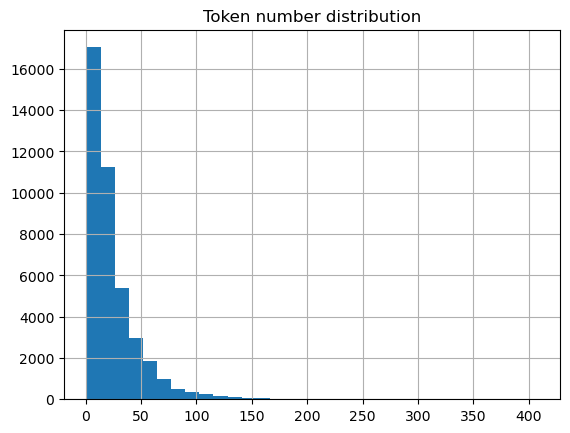

In [ ]:
df["tokens_num"] = df["clean_text"].apply(lambda x: len(x.split()))
df["tokens_num"].hist(bins=32)
plt.title("Token number distribution");

## Wordcloud

Let's draw a simple wordcloud for text which is considered as Hate and Not

In [ ]:
normal_text = " ".join(df[df["label"] == "nothate"]["clean_text"])
hate_text = " ".join(df[df["label"] == "hate"]["clean_text"])

def get_wordcloud(text, title=""):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    fig = plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)

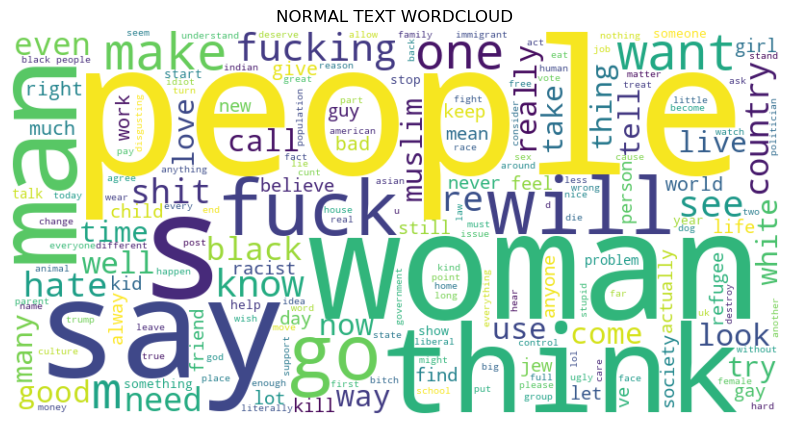

In [ ]:
get_wordcloud(normal_text, "NORMAL TEXT WORDCLOUD")

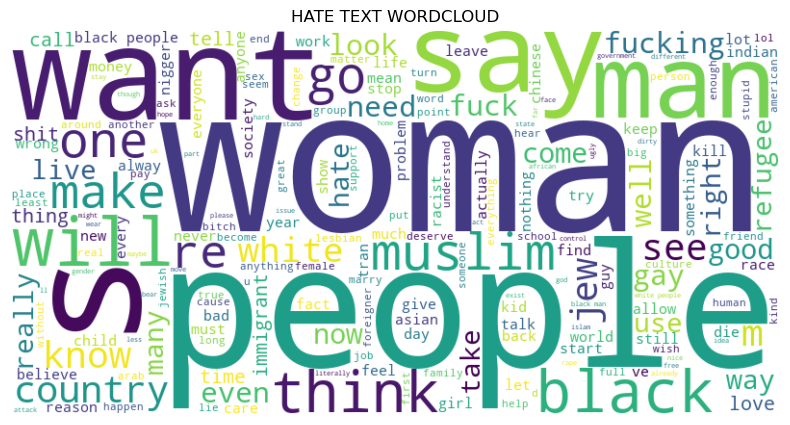

In [ ]:
get_wordcloud(hate_text, "HATE TEXT WORDCLOUD")

## Simple TF-IDF

In [ ]:
# Perform train-test split and text embedding with a simple TF-IDF
vectorizer = TfidfVectorizer()
y = df['is_hate']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(df["clean_text"], y, test_size=0.3, random_state=42)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

In [ ]:
def tune_lr(X_train, X_test, y_train, y_test, reg_params):
    train_acc, test_acc = [], []
    for c in tqdm(reg_params):
        model = LogisticRegression(C=c, max_iter=1000)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_acc.append(accuracy_score(y_train, y_train_pred))
        test_acc.append(accuracy_score(y_test, y_test_pred))
    return train_acc, test_acc

def plot_learning_curve(params, train_acc, test_acc):
    plt.grid()
    ax = sns.lineplot(x=reg_params, y=train_acc, label="Train accuracy")
    ax.set(xscale='log')
    sns.lineplot(x=reg_params, y=test_acc, label="Test accuracy")
    plt.xlabel("Inversed regularization strength")
    plt.ylabel("Accuracy")
    plt.title("Learning curve");

In [ ]:
# Tuning the inversed regularization strength of logistic regression
reg_params = np.logspace(-5, 3, 10)

train_acc, test_acc = tune_lr(X_train, X_test, y_train, y_test, reg_params)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.29it/s]


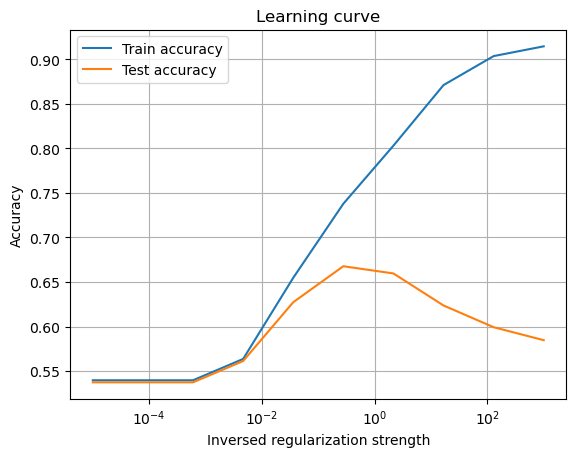

In [ ]:
# Plot the learning curve
plot_learning_curve(params, train_acc, test_acc)

In [ ]:
# Best model detailed analysis
best_lr = LogisticRegression(C=0.1)
best_lr.fit(X_train, y_train)

y_pred = best_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6604828256642904
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.51      0.58      5711
           1       0.65      0.79      0.72      6633

    accuracy                           0.66     12344
   macro avg       0.66      0.65      0.65     12344
weighted avg       0.66      0.66      0.65     12344



## Word2Vec

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
X = df["clean_text"].progress_apply(lambda x: nlp(x).vector).to_numpy()
X = np.stack(X)

100%|███████████████████████████████████████████████████████████████████████████| 41144/41144 [03:52<00:00, 176.86it/s]


In [ ]:
y = df['is_hate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Tuning the inversed regularization strength of logistic regression
reg_params = np.logspace(-5, 3, 10)

train_acc, test_acc = tune_lr(X_train, X_test, y_train, y_test, reg_params)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


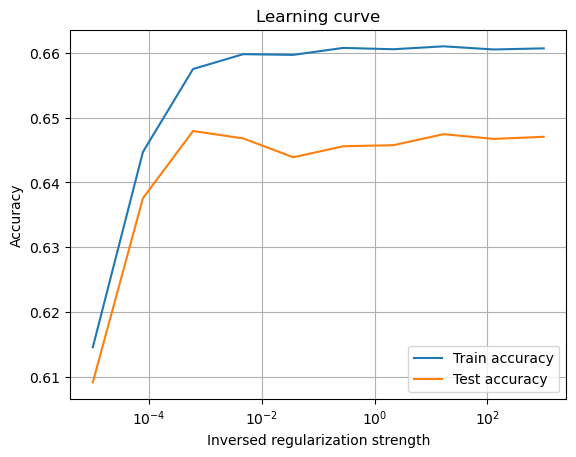

In [ ]:
# Plot the learning curve
plot_learning_curve(reg_params, train_acc, test_acc)

In [ ]:
# Best model detailed analysis
best_lr = LogisticRegression(C=0.001)
best_lr.fit(X_train, y_train)

y_pred = best_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6473590408295529
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.56      0.60      5711
           1       0.66      0.72      0.69      6633

    accuracy                           0.65     12344
   macro avg       0.65      0.64      0.64     12344
weighted avg       0.65      0.65      0.64     12344



## Pre-trained NN

In [ ]:
from transformers import AlbertForSequenceClassification, AlbertTokenizer

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn.functional import sigmoid

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

max_length = 128

model_save_path = "albert_hate_speech_model.pth"
tokenizer_save_path = "albert_tokenizer/"

In [ ]:
# df_sample = df.sample(frac=0.1, random_state=228)

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'].tolist(),
    df['is_hate'].tolist(),
    test_size=0.2,
    random_state=228
)

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HateSpeechDataset(train_encodings, train_labels)
test_dataset = HateSpeechDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [ ]:
def train_epoch_run(model, epoch, train_loader, optimizer, device):
    loop = tqdm(train_loader, position=0, leave=True)
    model.train()
    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []
    # Training batches sampling
    for batch in loop:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate training accuracy and loss
        epoch_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.cpu().numpy()
        preds = np.argmax(logits, axis=1)
        epoch_preds.extend(preds)
        epoch_labels.extend(label_ids)

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    epoch_accuracy = accuracy_score(epoch_labels, epoch_preds)

    return model, epoch_loss / len(train_loader), epoch_accuracy

def eval_epoch_run(model, test_loader, device):
    model.eval()
    predictions, true_labels = [], []
    test_loss, test_correct, test_total = 0, 0, 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            test_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_acc = test_correct / test_total

    return test_loss, test_acc, predictions, true_labels

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
n_epochs = 5

# Training loop
train_losses = []
train_accuraces = []
test_losses = []
test_accuraces = []
for epoch in range(1, n_epochs + 1):
    loop = tqdm(train_loader, leave=True)

    # Training batches sampling
    model, epoch_loss, epoch_accuracy = train_epoch_run(model, epoch, train_loader, optimizer, device)
    train_losses.append(epoch_loss)
    train_accuraces.append(epoch_accuracy)
    print(f"Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_accuracy:.4f}")

    # Test accuracy calculation
    test_loss, test_accuracy, _, _ = eval_epoch_run(model, test_loader, device)
    test_losses.append(test_loss)
    test_accuraces.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

Epoch 0: 100%|██████████| 515/515 [11:24<00:00,  1.33s/it, loss=0.621]


Training Loss: 0.5834 | Training Accuracy: 0.6754
Test Loss: 0.4955 | Test Accuracy: 0.7475



Epoch 1: 100%|██████████| 515/515 [11:23<00:00,  1.33s/it, loss=0.237]


Training Loss: 0.4456 | Training Accuracy: 0.7830
Test Loss: 0.4379 | Test Accuracy: 0.7830


Epoch 2: 100%|██████████| 515/515 [11:23<00:00,  1.33s/it, loss=0.145]


Training Loss: 0.3603 | Training Accuracy: 0.8314
Test Loss: 0.4466 | Test Accuracy: 0.7876



Epoch 3: 100%|██████████| 515/515 [11:22<00:00,  1.33s/it, loss=0.271]


Training Loss: 0.2849 | Training Accuracy: 0.8738
Test Loss: 0.4673 | Test Accuracy: 0.7856


Epoch 4: 100%|██████████| 515/515 [11:23<00:00,  1.33s/it, loss=0.11]


Training Loss: 0.2037 | Training Accuracy: 0.9148
Test Loss: 0.5735 | Test Accuracy: 0.7724


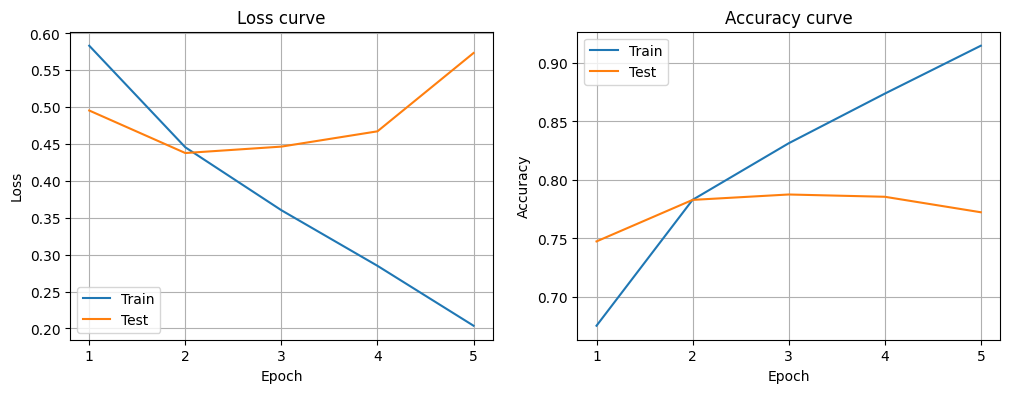

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss" if i == 0 else "Accuracy")
    ax[i].set_title(f"{'Loss' if i == 0 else 'Accuracy'} curve")
    sns.lineplot(x=range(1, n_epochs + 1), y=train_losses if i == 0 else train_accuraces, ax=ax[i], label="Train")
    sns.lineplot(x=range(1, n_epochs + 1), y=test_losses if i == 0 else test_accuraces, ax=ax[i], label="Test")
    ax[i].legend()
    ax[i].set(xticks=list(range(1, n_epochs + 1)))

In [ ]:
test_loss, test_accuracy, predictions, true_labels = eval_epoch_run(model, test_loader, device)

In [ ]:
# Print test classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.81      0.67      0.73      3835
           1       0.75      0.86      0.80      4394

    accuracy                           0.77      8229
   macro avg       0.78      0.77      0.77      8229
weighted avg       0.78      0.77      0.77      8229



In [ ]:
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('albert_tokenizer/tokenizer_config.json',
 'albert_tokenizer/special_tokens_map.json',
 'albert_tokenizer/spiece.model',
 'albert_tokenizer/added_tokens.json')

### Analyzing the model output

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained(tokenizer_save_path)
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2).to(device)
model.load_state_dict(torch.load(model_save_path))

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
test_texts[16]

'jeez transgender be about as legitimate as fairy and mermaid imho'

In [ ]:
# Example sentence
text_to_explain = "jeez transgender be about as legitimate as fairy and mermaid imho"

# Tokenize input text
tokens = tokenizer(text_to_explain, return_tensors='pt')

# Move tokens to the same device as the model
tokens = {k: v.to(device) for k, v in tokens.items()}

# Get model outputs with attention
outputs = model(**tokens, output_attentions=True)

# Extract attention weights from the last layer
# outputs.attentions is a tuple of attention scores from all layers and heads
attentions = outputs.attentions[-1]  # Last layer
attention_scores = attentions[0][0].detach().cpu().numpy()  # First head, batch size 1

In [ ]:
probs = sigmoid(outputs.logits)
print("Probability of HATE: %.4f" % probs[0][1].item())
print("Probability of NON-HATE: %.4f" % probs[0][0].item())

Probability of HATE: 0.7116
Probability of NON-HATE: 0.2455


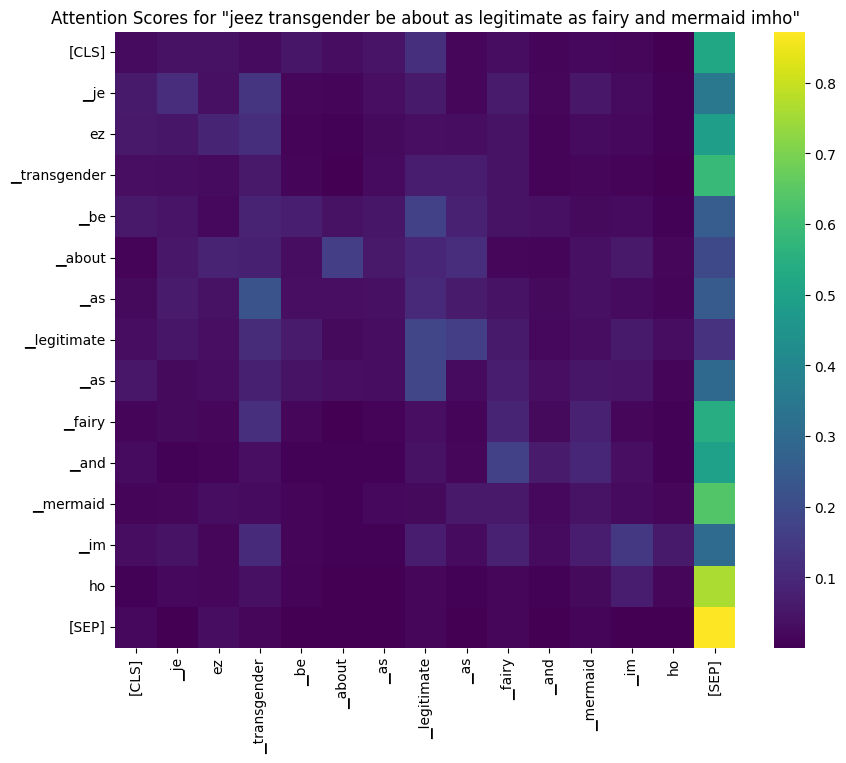

In [ ]:
# Get the tokens (convert ids to tokens)
tokens_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])

# Plot the attention scores as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_scores[:len(tokens_text), :len(tokens_text)], xticklabels=tokens_text, yticklabels=tokens_text, cmap='viridis')
plt.title(f'Attention Scores for "{text_to_explain}"')
plt.show()